# Use `LAmatrix` to correct K2 Motion

The K2 mission had a characteristic roll motion in its data, which imparted a strong, multiplicative saw-tooth pattern. We can use `LAmatrix` to fit and remove this systematic noise quite easily!

First off we'll get the data. I include this here as a simple csv file in the `docs/use-cases/data` folder on GitHub.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
time, flux, flux_err, col, row = np.asarray([[float(a) if a != "" else np.nan for a in ar] for ar in np.loadtxt("data/k218.csv", skiprows=1, delimiter=',', dtype=str).T])
col -= np.nanmedian(col)
row -= np.nanmedian(row)

k = (np.abs(col) < 3) & (np.abs(row) < 3)
time, flux, flux_err, col, row = time[k], flux[k], flux_err[k], col[k], row[k] 
time -= time.mean()

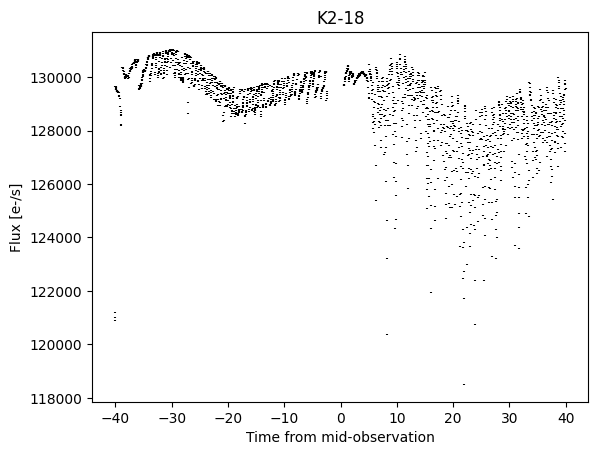

In [3]:
fig, ax = plt.subplots()
ax.errorbar(time, flux, flux_err, ls='', color='k')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');

This data is in flux, and the systematic is multiplicative. We will make the assumption this dataset encompases **one** source, and so when we take the log of this data the systematics become additive. 

In [4]:
y = np.log10(flux)
ye = flux_err/(flux * np.log(10))

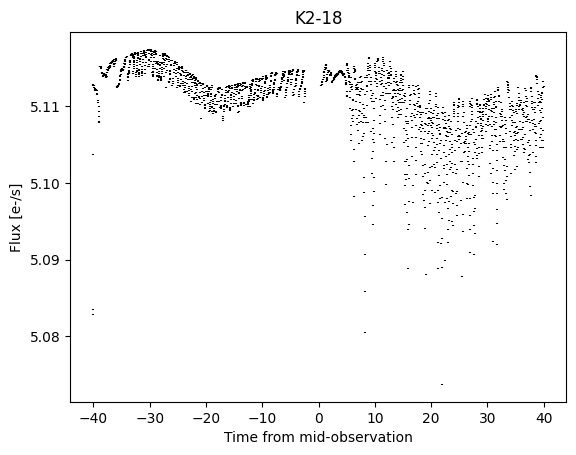

In [5]:
fig, ax = plt.subplots()
ax.errorbar(time, y, ye, ls='', color='k')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');

In [6]:
acceleration = np.hypot(np.gradient(np.gradient(row, time), time), np.gradient(np.gradient(col, time), time))
acceleration -= np.median(acceleration)
outliers = acceleration > (5*-np.percentile(acceleration, 40))

Now we have our data we can fit a model. First we'll import `LAmatrix`

In [7]:
import lamatrix as la

We're going to fit a simple model to this data. We'll assume that the flux is a strong function of 

- The column position of the source
- The row position of the source

We know that the spacecraft may not move exactly across the column dimension, or exactly across the row dimension. Because of this, the cross terms are probably important. So, we will create a **2D, cubic polynomial in column and row**.

In [8]:
p1 = la.Polynomial1DGenerator(x_name='c', polyorder=3)
p2 = la.Polynomial1DGenerator(x_name='r', polyorder=3)

# Combine the two models, taking the cross terms
systematics = (p1 * p2)

We can create a simple spline

In [9]:
astro = la.Spline1DGenerator(np.linspace(time.min(), time.max(), 40), x_name='t')

In [10]:
model = systematics + astro

In [11]:
model.fit(c=col, r=row, t=time, data=y, errors=ye, mask=~outliers)

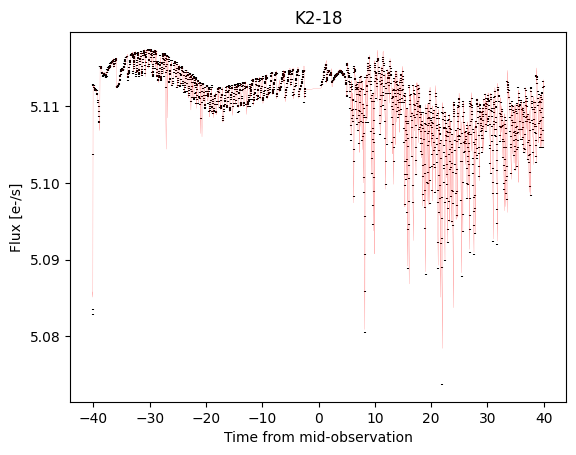

In [12]:
fig, ax = plt.subplots()
ax.errorbar(time, y, ye, ls='', color='k')
ax.plot(time, model(c=col, r=row, t=time, dc=np.gradient(col, time), dr=np.gradient(row, time)), c='r', lw=0.1)
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');

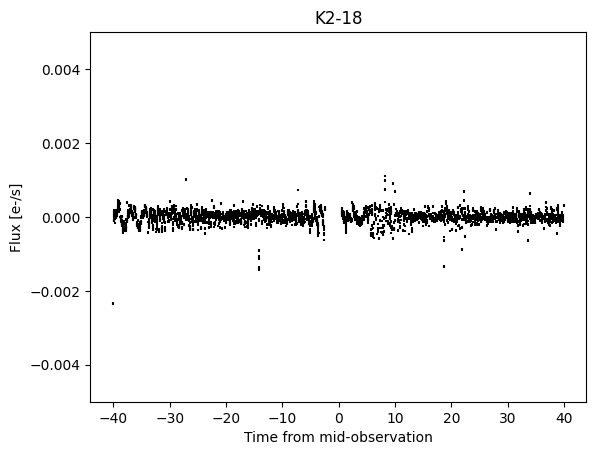

In [13]:
fig, ax = plt.subplots()
r = y - model(c=col, r=row, dc=np.gradient(col, time), dr=np.gradient(row, time), t=time)
ax.errorbar(time[~outliers], r[~outliers], ye[~outliers], ls='', color='k')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18', ylim=(-0.005, 0.005));

Something wrong with the bounds and how they are set up...

In [52]:
p1 = la.Polynomial1DGenerator(x_name='c', polyorder=3, offset_prior=(0, 0))
p2 = la.Polynomial1DGenerator(x_name='r', polyorder=3, offset_prior=(0, 0))

#p1 = la.BoundedGenerator(p1, x_name='t', bounds=[(-50, 0), (0, 50)])
systematics = p1 * p2
systematics = la.BoundedGenerator(p1 * p2, x_name='t', bounds=[(-50, 0), (0, 50)])


astro = la.Spline1DGenerator(np.linspace(time.min(), time.max(), 40), x_name='t')

model = systematics + astro

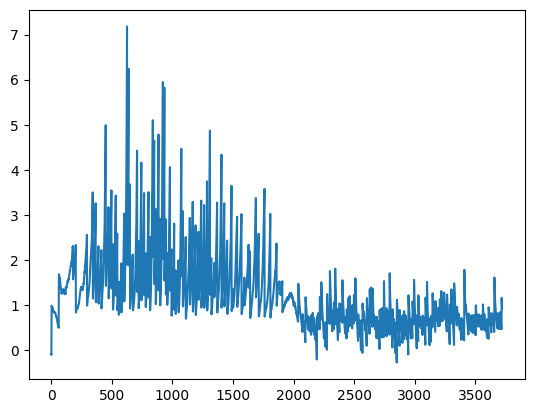

In [53]:
plt.plot(systematics.design_matrix(c=col, r=row, t=time).dot(np.ones(systematics.width)))

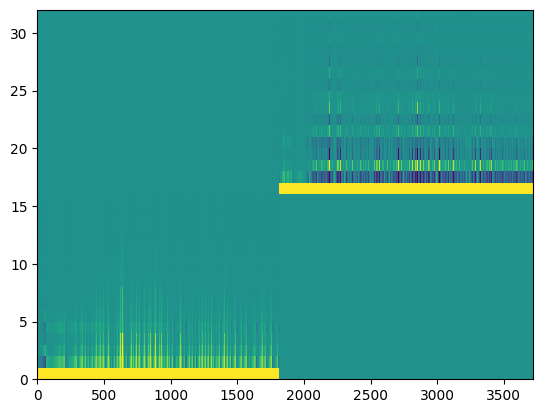

In [54]:
plt.pcolormesh(systematics.design_matrix(c=col, r=row, t=time).T, vmin=-1, vmax=1)

In [55]:
model.fit(c=col, r=row, t=time, data=y, errors=ye, mask=~outliers)

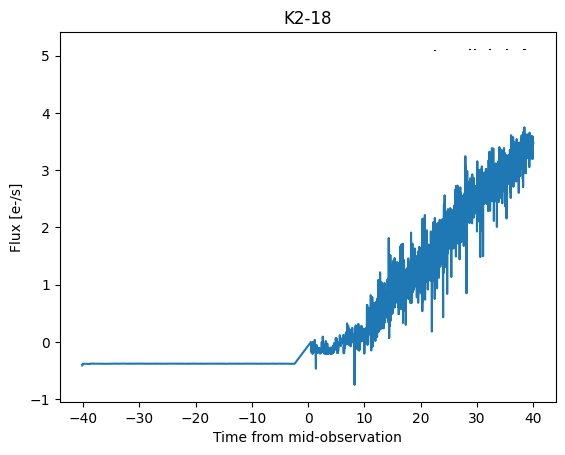

In [57]:
fig, ax = plt.subplots()
ax.errorbar(time, y, ye, ls='', color='k')
ax.plot(time, model[0](c=col, r=row, t=time))
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');#, ylim=(-0.005, 0.005));

In [38]:
p1 = la.Polynomial1DGenerator(x_name='c', polyorder=3)
p2 = la.Polynomial1DGenerator(x_name='r', polyorder=3)
p3 = la.Polynomial1DGenerator(x_name='t', polyorder=3)

p1 = la.BoundedGenerator(p1, x_name='t', bounds=[(-50, 0), (0, 50)])

systematics = p1 * p2 #* p3

astro = la.Spline1DGenerator(np.linspace(time.min(), time.max(), 40), x_name='t')

model = systematics + astro

In [39]:
model.fit(c=col, r=row, t=time, data=y, errors=ye, mask=~outliers)

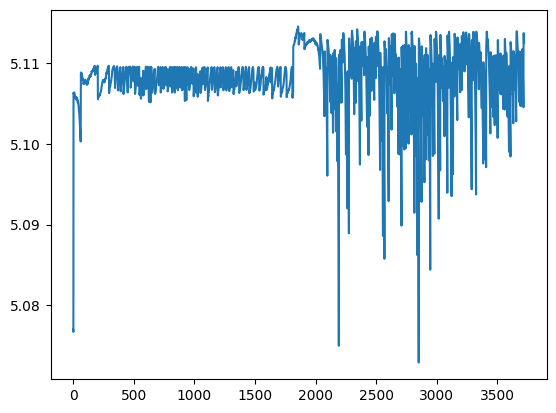

In [40]:
plt.plot(model[0](c=col, r=row, t=time))

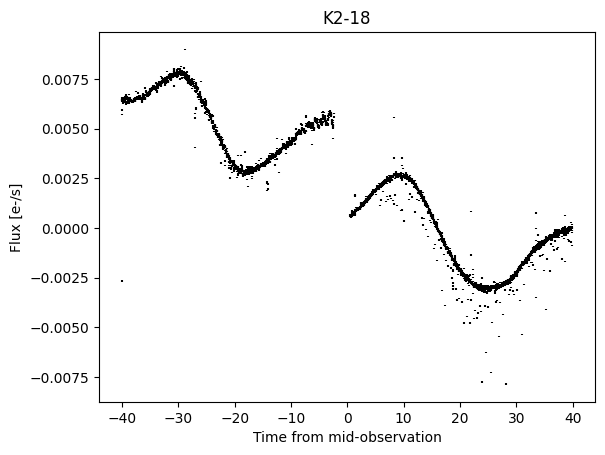

In [41]:
fig, ax = plt.subplots()
ax.errorbar(time, y - model[0](c=col, r=row, t=time), ye, ls='', color='k')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');

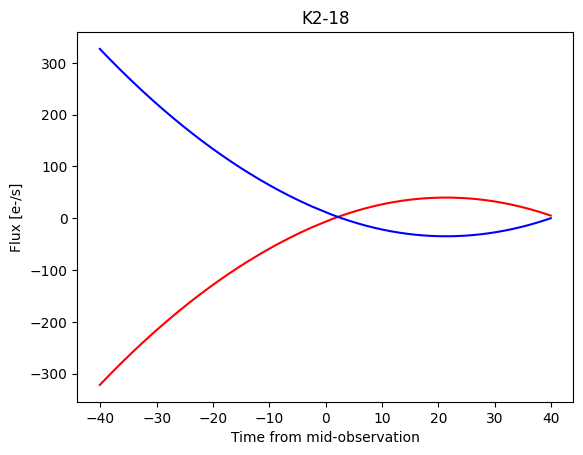

In [38]:
fig, ax = plt.subplots()
ax.errorbar(time, y, ye, ls='', color='k')
ax.plot(time, model[0](c=col, r=row, t=time), color='r')
ax.plot(time, model[1](c=col, r=row, t=time), color='b')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');

In [39]:
p1 = la.Polynomial1DGenerator(x_name='c', polyorder=3)
p2 = la.Polynomial1DGenerator(x_name='r', polyorder=3)

p1 = la.BoundedGenerator(p1, x_name='t', bounds=[(-50, 0), (0, 50)])

systematics = p1 * p2 

astro = la.Spline1DGenerator(np.linspace(time.min(), time.max(), 40), x_name='t')

model = systematics + astro

model.fit(c=col, r=row, t=time, data=y, errors=ye, mask=~outliers)

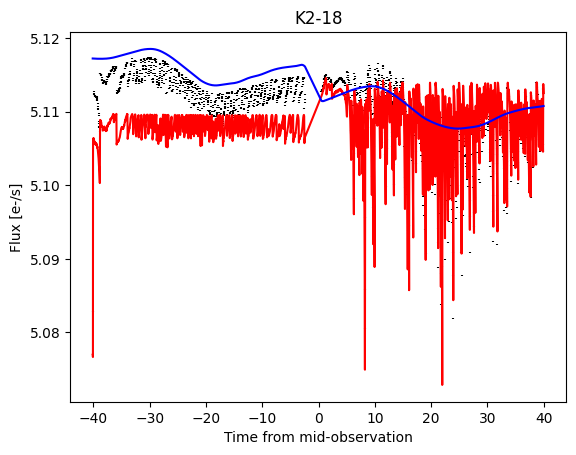

In [40]:
fig, ax = plt.subplots()
ax.errorbar(time, y, ye, ls='', color='k')
ax.plot(time, model[0](c=col, r=row, t=time), color='r')
ax.plot(time, model[1](c=col, r=row, t=time) + y.mean(), color='b')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');

In [41]:
astro_with_updated_priors = model[1].update_priors()

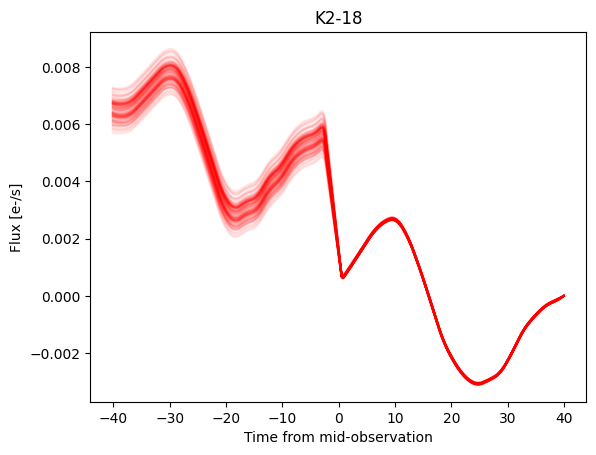

In [42]:
fig, ax = plt.subplots()
ax.plot(time, astro_with_updated_priors.sample(t=time, size=100), alpha=0.1, c='r');
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');

In [43]:
p1 = la.Polynomial1DGenerator(x_name='c', polyorder=3)
p2 = la.Polynomial1DGenerator(x_name='r', polyorder=3)
p3 = la.Polynomial1DGenerator(x_name='t', polyorder=1)

p3 = la.BoundedGenerator(p3, x_name='t', bounds=[(-50, 0), (0, 50)])

systematics = p1 * p2 * p3

model = systematics + astro_with_updated_priors

model.fit(c=col, r=row, t=time, data=y, errors=ye, mask=~outliers)

resids = np.abs((y - model.evaluate(c=col, r=row, t=time))/ye)

model.fit(c=col, r=row, t=time, data=y, errors=ye, mask=~outliers & (resids < 6))

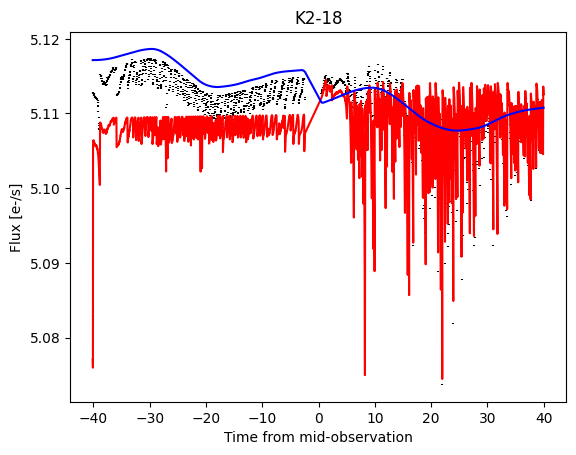

In [44]:
fig, ax = plt.subplots()
ax.errorbar(time, y, ye, ls='', color='k')
ax.plot(time, model[0](c=col, r=row, t=time), color='r')
ax.plot(time, model[1](c=col, r=row, t=time) + y.mean(), color='b')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18');

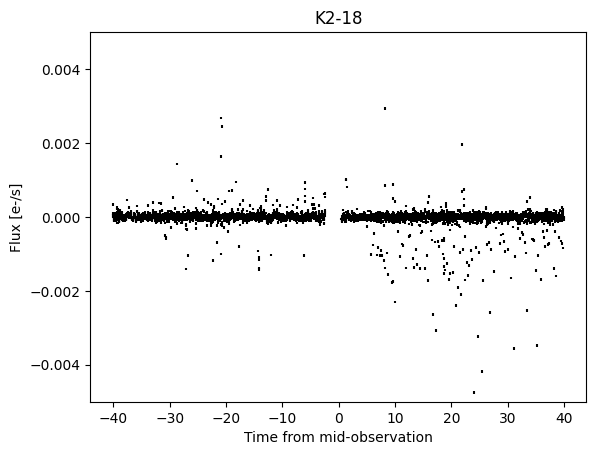

In [45]:
fig, ax = plt.subplots()
ax.errorbar(time, y - model(c=col, r=row, t=time), ye, ls='', color='k')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18', ylim=(-0.005, 0.005));

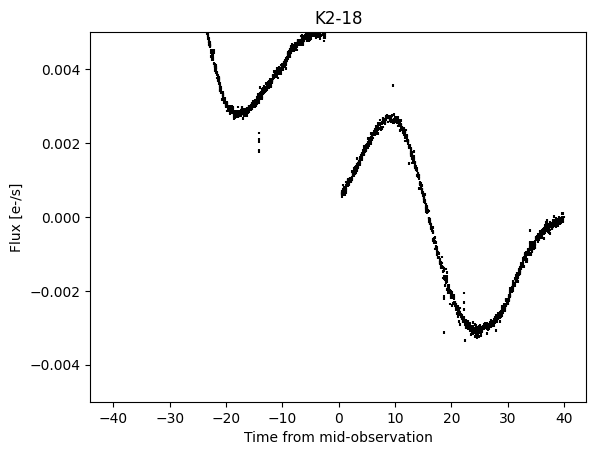

In [46]:
fig, ax = plt.subplots()
ax.errorbar(time[~outliers], (y - model[0](c=col, r=row, t=time))[~outliers], ye[~outliers], ls='', color='k')
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='K2-18', ylim=(-0.005, 0.005));

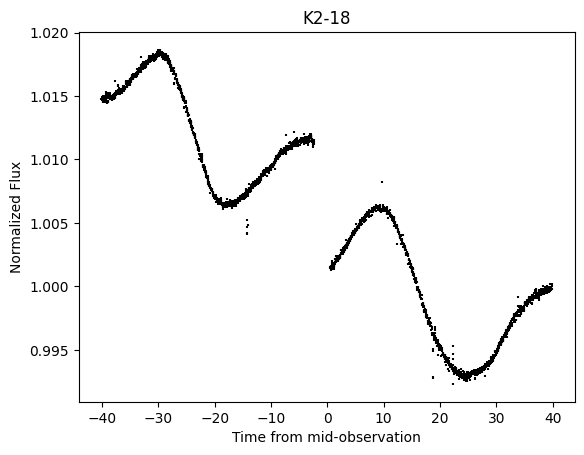

In [47]:
fig, ax = plt.subplots()
lc = 10**(y - model[0](c=col, r=row, t=time))
lc_err = lc * (flux_err/flux)
ax.errorbar(time[~outliers], lc[~outliers], lc_err[~outliers], ls='', color='k')
ax.set(xlabel='Time from mid-observation', ylabel='Normalized Flux', title='K2-18');